In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
import time
import csv
import gzip
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
HIDDEN_SIZE = 100
BATCH_SIZE = 256
N_LAYER = 2
N_EPOCHS = 100
N_CHARS = 128 #英文字符字典的长度，采用ASCLL码最大128

In [3]:
class NameDataset(Dataset):
    def __init__(self, is_train_set=True):
        super(NameDataset, self).__init__()
        filename = './names_train.csv.gz' if is_train_set else './names_test.csv.gz'
        with gzip.open(filename, 'rt') as f:
            reader = csv.reader(f)
            rows = list(reader)
        self.names = [row[0] for row in rows]
        self.len = len(self.names)
        self.countries = [row[1] for row in rows]
        self.country_list = list(sorted(set(self.countries))) # set函数列表变集合，去除重复的实例
        self.country_dict = self.getCountryDict()
        self.country_num = len(self.country_list)
    
    def __getitem__(self, index):
        return self.names[index], self.country_dict[self.countries[index]]
    
    def __len__(self):
        return self.len
    
    def getCountryDict(self):
        country_dict = dict()
        for idx, country_name in enumerate(self.country_list, 0):
            country_dict[country_name] = idx
        return country_dict
    
    def idx2country(self, index):
        return self.country_list[index]
    
    def getCountriesNum(self):
        return self.country_num

In [4]:
trainset = NameDataset(is_train_set=True)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testset = NameDataset(is_train_set=False)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

N_COUNTRY = trainset.getCountriesNum()

In [5]:
class RNNClassifier(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1, bidirectional=True):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_directions = 2 if bidirectional else 1

        self.embedding = torch.nn.Embedding(input_size, hidden_size) # input_size = dict_size, hidden_size = embedding_size
        self.gru = torch.nn.GRU(hidden_size, hidden_size, n_layers, bidirectional=bidirectional) # hidden_size = embedding_size
        self.fc = torch.nn.Linear(hidden_size*self.n_directions, output_size)

    def _init_hidden(self, batch_size):
        # 使用 create_tensor 确保 hidden 在模型所在设备上
        hidden = torch.zeros(self.n_layers * self.n_directions, batch_size, self.hidden_size, device=self.embedding.weight.device)
        return hidden
    
    def forward(self, input, seq_lengths):
        input = input.t() # 转置将(batch, seq_len)变为(seq_len, batch)
        batch_size = input.size(1)

        hidden=self._init_hidden(batch_size)
        embedding = self.embedding(input)
        # pack the input list to speed up the calculation
        gru_input = torch.nn.utils.rnn.pack_padded_sequence(embedding,seq_lengths)

        output, hidden = self.gru(gru_input, hidden)
        if self.n_directions==2:
            hidden_cat = torch.cat([hidden[-1], hidden[-2]], dim=1)
        else:
            hidden_cat = hidden[-1]
        fc_output=self.fc(hidden_cat)
        return fc_output


In [6]:
def name2list(name):
    arr=[ord(c) for c in name] # 将名字的string拆分成char，并转换为list
    return arr,len(arr)
def create_tensor(tensor):
    return tensor

def make_tensors(names,countries):
    sequences_and_lengths = [name2list(name) for name in names] # names是一个序列，包含[name, seq_len]
    name_sequences = [sl[0] for sl in sequences_and_lengths]
    seq_lengths = torch.LongTensor([sl[1] for sl in sequences_and_lengths])

    seq_tensor = torch.zeros(len(name_sequences),seq_lengths.max()).long()
    for idx,(seq,seq_len) in enumerate(zip(name_sequences,seq_lengths),0):
        seq_tensor[idx, :seq_len] = torch.LongTensor(seq)

    seq_lengths,perm_idx=seq_lengths.sort(dim=0,descending=True) # 将原始数据按照序列长度从大到小排序的排列顺序，用于对数据进行重排序
    seq_tensor=seq_tensor[perm_idx]
    countries=countries[perm_idx]
    return create_tensor(seq_tensor), create_tensor(seq_lengths), create_tensor(countries)

In [7]:
def trainModel():
    classifier.to(device)  # 确保模型在 GPU 上
    total_loss = 0
    for i, (names, countries) in enumerate(trainloader, 1):
        inputs, seq_lengths, target = make_tensors(names, countries)
        
        # 数据移动到 GPU
        inputs = inputs.to(device)
        target = target.to(device)
        
        # 注意 seq_lengths 必须放到 CPU
        seq_lengths = seq_lengths.to('cpu')

        # 前向传播
        output = classifier(inputs, seq_lengths)
        loss = criterion(output, target)

        # 反向传播与优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if i % 10 == 0:
            end = time.time()
            print(f'[{end - start}] Epoch {epoch}', end=' ')
            print(f'[{i * len(inputs)}/{len(trainset)}]', end=' ')
            print(f'loss = {total_loss / (i * len(inputs)):.4f}')

    return total_loss


In [8]:
def testModel():
    classifier.to(device)  # 确保模型在 GPU 上
    correct = 0
    total = len(testset)
    print("Evaluating trained model...")
    with torch.no_grad():
        for i, (names, countries) in enumerate(testloader, 1):
            inputs, seq_lengths, target = make_tensors(names, countries)

            # 数据移动到 GPU
            inputs = inputs.to(device)
            target = target.to(device)

            # 注意 seq_lengths 必须放到 CPU
            seq_lengths = seq_lengths.to('cpu')

            # 前向传播
            output = classifier(inputs, seq_lengths)
            pred = output.max(dim=1, keepdim=True)[1]  # 取预测结果
            correct += pred.eq(target.view_as(pred)).sum().item()

        percent = f'{100 * correct / total:.2f}'
        print(f'Test set: Accuracy {correct}/{total} ({percent}%)')
    return correct / total

In [9]:
if __name__ == '__main__':
    classifier = RNNClassifier(N_CHARS, HIDDEN_SIZE, N_COUNTRY, N_LAYER)

    USE_GPU = True

    if USE_GPU:
        device = torch.device("cuda:0")
        classifier.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

    start = time.time()
    print("Training for %d epochs..." % N_EPOCHS)
    acc_list = []

    for epoch in range(1, N_EPOCHS + 1):
        # Train cycle
        trainModel()
        acc = testModel()
        acc_list.append(acc)

Training for 100 epochs...
[0.643531322479248] Epoch 1 [2560/13374] loss = 0.0086
[0.7757630348205566] Epoch 1 [5120/13374] loss = 0.0074
[0.9067447185516357] Epoch 1 [7680/13374] loss = 0.0068
[1.0405769348144531] Epoch 1 [10240/13374] loss = 0.0064
[1.174243688583374] Epoch 1 [12800/13374] loss = 0.0060
Evaluating trained model...
Test set: Accuracy 4434/6700 (66.18%)
[1.4756388664245605] Epoch 2 [2560/13374] loss = 0.0042
[1.6048316955566406] Epoch 2 [5120/13374] loss = 0.0042
[1.7320022583007812] Epoch 2 [7680/13374] loss = 0.0040
[1.863473892211914] Epoch 2 [10240/13374] loss = 0.0039
[1.9853074550628662] Epoch 2 [12800/13374] loss = 0.0038
Evaluating trained model...
Test set: Accuracy 4970/6700 (74.18%)
[2.2523858547210693] Epoch 3 [2560/13374] loss = 0.0031
[2.3745760917663574] Epoch 3 [5120/13374] loss = 0.0032
[2.497565746307373] Epoch 3 [7680/13374] loss = 0.0031
[2.6168582439422607] Epoch 3 [10240/13374] loss = 0.0031
[2.7413394451141357] Epoch 3 [12800/13374] loss = 0.0030

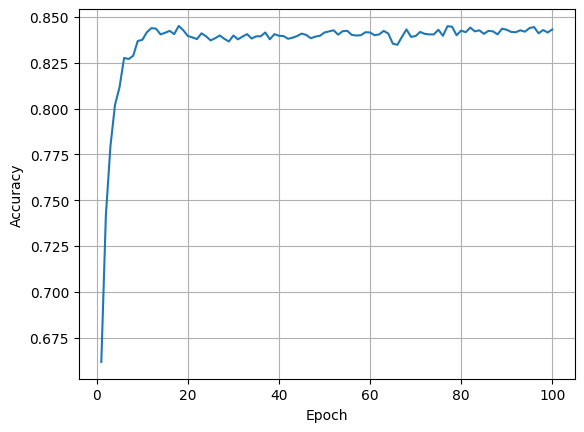

In [10]:
epoch1 = np.arange(1,len(acc_list)+1,1)
acc_list1=np.array(acc_list)
plt.plot(epoch1,acc_list1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()